In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [2]:
base_dir = Path.cwd()
if base_dir.name == "project-3":
    data_dir = base_dir / "data"
    figures_dir = base_dir / "figures"
else:
    data_dir = base_dir / "project-3" / "data"
    figures_dir = base_dir / "project-3" / "figures"

figures_dir.mkdir(exist_ok=True)

mistral_file = data_dir / "model_outputs" / "all_indicators_evaluations_mistral-7b-instruct.json"
llama_file = data_dir / "model_outputs" / "all_indicators_evaluations_llama-2-7b-chat.json"

print(f"Loading Mistral evaluations from: {mistral_file}")
with open(mistral_file, 'r', encoding='utf-8') as f:
    mistral_data = json.load(f)

print(f"Loading Llama-2 evaluations from: {llama_file}")
with open(llama_file, 'r', encoding='utf-8') as f:
    llama_data = json.load(f)

print(f"\nMistral model: {mistral_data['model']}")
print(f"Llama-2 model: {llama_data['model']}")
print(f"Total prompts evaluated (Mistral): {mistral_data['total_prompts']}")
print(f"Total prompts evaluated (Llama-2): {llama_data['total_prompts']}")


Loading Mistral evaluations from: /Users/Studies/Documents/Notes/AI-Ethics/project-3/data/model_outputs/all_indicators_evaluations_mistral-7b-instruct.json
Loading Llama-2 evaluations from: /Users/Studies/Documents/Notes/AI-Ethics/project-3/data/model_outputs/all_indicators_evaluations_llama-2-7b-chat.json

Mistral model: Mistral-7B-Instruct
Llama-2 model: Llama-2-7b-chat
Total prompts evaluated (Mistral): 880
Total prompts evaluated (Llama-2): 880


In [3]:
def extract_scores_by_indicator(eval_data):
    scores_by_indicator = defaultdict(list)
    prompt_scores = defaultdict(dict)
    
    for prompt_id, eval_info in eval_data['evaluations'].items():
        for indicator, eval_result in eval_info['indicators'].items():
            score = eval_result.get('score')
            if score is not None:
                scores_by_indicator[indicator].append(score)
                if prompt_id not in prompt_scores:
                    prompt_scores[prompt_id] = {}
                prompt_scores[prompt_id][indicator] = score
    
    return scores_by_indicator, prompt_scores

mistral_scores, mistral_prompt_scores = extract_scores_by_indicator(mistral_data)
llama_scores, llama_prompt_scores = extract_scores_by_indicator(llama_data)

indicators = sorted(set(list(mistral_scores.keys()) + list(llama_scores.keys())))
print(f"Indicators found: {indicators}")

print("\nSample sizes per indicator:")
for ind in indicators:
    mistral_n = len(mistral_scores.get(ind, []))
    llama_n = len(llama_scores.get(ind, []))
    print(f"  {ind}: Mistral={mistral_n}, Llama-2={llama_n}")


Indicators found: ['L4.1', 'L4.2', 'L4.3', 'L4.4', 'L4.5', 'L4.6', 'L4.7']

Sample sizes per indicator:
  L4.1: Mistral=598, Llama-2=598
  L4.2: Mistral=598, Llama-2=598
  L4.3: Mistral=193, Llama-2=193
  L4.4: Mistral=511, Llama-2=511
  L4.5: Mistral=168, Llama-2=168
  L4.6: Mistral=168, Llama-2=168
  L4.7: Mistral=310, Llama-2=310


In [4]:
def calculate_confidence_interval(data, confidence=0.95):
    if len(data) == 0:
        return None, None, None
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - h, mean + h

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    if pooled_std == 0:
        return 0
    return (np.mean(group1) - np.mean(group2)) / pooled_std

comparison_results = []

for ind in indicators:
    mistral_scores_list = np.array(mistral_scores.get(ind, []))
    llama_scores_list = np.array(llama_scores.get(ind, []))
    
    if len(mistral_scores_list) == 0 or len(llama_scores_list) == 0:
        continue
    
    mistral_mean, mistral_ci_low, mistral_ci_high = calculate_confidence_interval(mistral_scores_list)
    llama_mean, llama_ci_low, llama_ci_high = calculate_confidence_interval(llama_scores_list)
    
    t_stat, t_pvalue = stats.ttest_ind(mistral_scores_list, llama_scores_list)
    
    u_stat, u_pvalue = stats.mannwhitneyu(mistral_scores_list, llama_scores_list, alternative='two-sided')
    
    effect_size = cohens_d(mistral_scores_list, llama_scores_list)
    
    mean_diff = mistral_mean - llama_mean
    
    comparison_results.append({
        'Indicator': ind,
        'Mistral_Mean': mistral_mean,
        'Mistral_CI_Low': mistral_ci_low,
        'Mistral_CI_High': mistral_ci_high,
        'Mistral_Std': np.std(mistral_scores_list, ddof=1),
        'Mistral_N': len(mistral_scores_list),
        'Llama_Mean': llama_mean,
        'Llama_CI_Low': llama_ci_low,
        'Llama_CI_High': llama_ci_high,
        'Llama_Std': np.std(llama_scores_list, ddof=1),
        'Llama_N': len(llama_scores_list),
        'Mean_Difference': mean_diff,
        'T_Statistic': t_stat,
        'T_PValue': t_pvalue,
        'MannWhitney_U': u_stat,
        'MannWhitney_PValue': u_pvalue,
        'Cohens_D': effect_size
    })

comparison_df = pd.DataFrame(comparison_results)
print("Comparative Analysis Results:")
print("=" * 100)
print(comparison_df.to_string(index=False))


Comparative Analysis Results:
Indicator  Mistral_Mean  Mistral_CI_Low  Mistral_CI_High  Mistral_Std  Mistral_N  Llama_Mean  Llama_CI_Low  Llama_CI_High  Llama_Std  Llama_N  Mean_Difference  T_Statistic     T_PValue  MannWhitney_U  MannWhitney_PValue  Cohens_D
     L4.1      4.005017        3.999338         4.010696     0.070710        598    4.006689      3.991281       4.022097   0.191849      598        -0.001672    -0.200000 8.415146e-01       177897.5        4.846245e-01 -0.011566
     L4.2      4.871237        4.844316         4.898159     0.335217        598    4.961538      4.942340       4.980737   0.239050      598        -0.090301    -5.363381 9.800849e-08       161537.0        8.153263e-10 -0.310172
     L4.3      4.284974        4.217530         4.352418     0.475035        193    4.512953      4.441805       4.584102   0.501132      193        -0.227979    -4.586798 6.101592e-06        14477.5        9.239282e-06 -0.466924
     L4.4      4.258317        4.216177         4.

In [5]:
summary_table = comparison_df[['Indicator', 'Mistral_Mean', 'Mistral_CI_Low', 'Mistral_CI_High', 
                                 'Llama_Mean', 'Llama_CI_Low', 'Llama_CI_High', 
                                 'Mean_Difference', 'T_PValue', 'MannWhitney_PValue', 'Cohens_D']].copy()

summary_table['Mistral_Mean'] = summary_table['Mistral_Mean'].round(3)
summary_table['Mistral_CI_Low'] = summary_table['Mistral_CI_Low'].round(3)
summary_table['Mistral_CI_High'] = summary_table['Mistral_CI_High'].round(3)
summary_table['Llama_Mean'] = summary_table['Llama_Mean'].round(3)
summary_table['Llama_CI_Low'] = summary_table['Llama_CI_Low'].round(3)
summary_table['Llama_CI_High'] = summary_table['Llama_CI_High'].round(3)
summary_table['Mean_Difference'] = summary_table['Mean_Difference'].round(3)
summary_table['T_PValue'] = summary_table['T_PValue'].round(4)
summary_table['MannWhitney_PValue'] = summary_table['MannWhitney_PValue'].round(4)
summary_table['Cohens_D'] = summary_table['Cohens_D'].round(3)

summary_table['Significant_T'] = summary_table['T_PValue'] < 0.05
summary_table['Significant_MW'] = summary_table['MannWhitney_PValue'] < 0.05

print("\nSummary Table for Paper:")
print("=" * 120)
print(summary_table.to_string(index=False))

print("\n\nSignificance Summary:")
print("=" * 60)
for _, row in summary_table.iterrows():
    sig_t = "Yes" if row['Significant_T'] else "No"
    sig_mw = "Yes" if row['Significant_MW'] else "No"
    effect = "Small" if abs(row['Cohens_D']) < 0.2 else "Medium" if abs(row['Cohens_D']) < 0.5 else "Large"
    print(f"{row['Indicator']}: T-test p={row['T_PValue']:.4f} ({sig_t}), "
          f"MW p={row['MannWhitney_PValue']:.4f} ({sig_mw}), "
          f"Effect={row['Cohens_D']:.3f} ({effect})")



Summary Table for Paper:
Indicator  Mistral_Mean  Mistral_CI_Low  Mistral_CI_High  Llama_Mean  Llama_CI_Low  Llama_CI_High  Mean_Difference  T_PValue  MannWhitney_PValue  Cohens_D  Significant_T  Significant_MW
     L4.1         4.005           3.999            4.011       4.007         3.991          4.022           -0.002    0.8415              0.4846    -0.012          False           False
     L4.2         4.871           4.844            4.898       4.962         4.942          4.981           -0.090    0.0000              0.0000    -0.310           True            True
     L4.3         4.285           4.218            4.352       4.513         4.442          4.584           -0.228    0.0000              0.0000    -0.467           True            True
     L4.4         4.258           4.216            4.300       4.339         4.294          4.383           -0.080    0.0101              0.0092    -0.161           True            True
     L4.5         4.583           4.503     

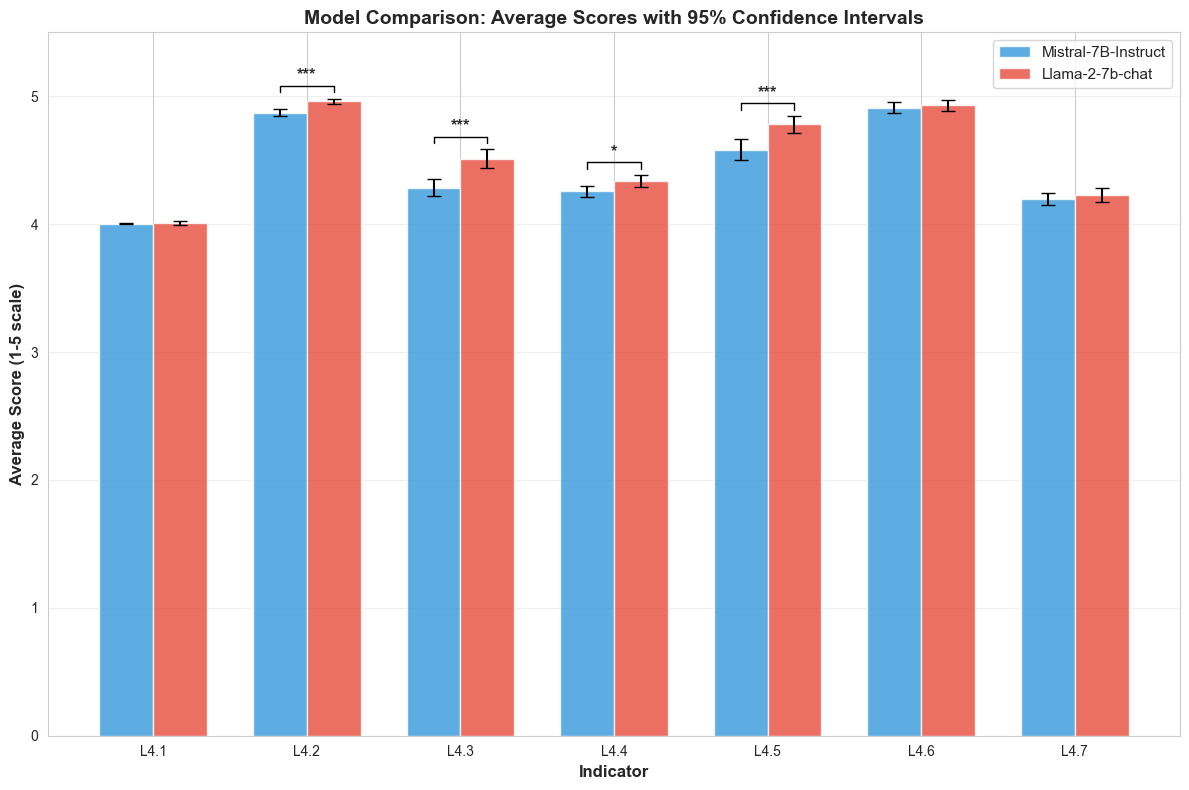

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(indicators))
width = 0.35

mistral_means = [comparison_df[comparison_df['Indicator'] == ind]['Mistral_Mean'].values[0] for ind in indicators]
llama_means = [comparison_df[comparison_df['Indicator'] == ind]['Llama_Mean'].values[0] for ind in indicators]

mistral_ci_low = [comparison_df[comparison_df['Indicator'] == ind]['Mistral_CI_Low'].values[0] for ind in indicators]
mistral_ci_high = [comparison_df[comparison_df['Indicator'] == ind]['Mistral_CI_High'].values[0] for ind in indicators]
llama_ci_low = [comparison_df[comparison_df['Indicator'] == ind]['Llama_CI_Low'].values[0] for ind in indicators]
llama_ci_high = [comparison_df[comparison_df['Indicator'] == ind]['Llama_CI_High'].values[0] for ind in indicators]

mistral_errors_low = [mistral_means[i] - mistral_ci_low[i] for i in range(len(indicators))]
mistral_errors_high = [mistral_ci_high[i] - mistral_means[i] for i in range(len(indicators))]
llama_errors_low = [llama_means[i] - llama_ci_low[i] for i in range(len(indicators))]
llama_errors_high = [llama_ci_high[i] - llama_means[i] for i in range(len(indicators))]

bars1 = ax.bar(x - width/2, mistral_means, width, label='Mistral-7B-Instruct', 
               yerr=[mistral_errors_low, mistral_errors_high], capsize=5, alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, llama_means, width, label='Llama-2-7b-chat', 
               yerr=[llama_errors_low, llama_errors_high], capsize=5, alpha=0.8, color='#e74c3c')

ax.set_xlabel('Indicator', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Score (1-5 scale)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: Average Scores with 95% Confidence Intervals', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(indicators, rotation=0)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 5.5])

for i, ind in enumerate(indicators):
    row = comparison_df[comparison_df['Indicator'] == ind].iloc[0]
    if row['T_PValue'] < 0.05:
        y_pos = max(mistral_ci_high[i], llama_ci_high[i]) + 0.1
        ax.plot([i - width/2, i + width/2], [y_pos, y_pos], 'k-', linewidth=1)
        ax.plot([i - width/2, i - width/2], [y_pos - 0.05, y_pos], 'k-', linewidth=1)
        ax.plot([i + width/2, i + width/2], [y_pos - 0.05, y_pos], 'k-', linewidth=1)
        p_val = row['T_PValue']
        sig_text = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
        ax.text(i, y_pos + 0.05, sig_text, ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / "model_comparison_bar_chart.png", dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / "model_comparison_bar_chart.pdf", bbox_inches='tight')
plt.show()


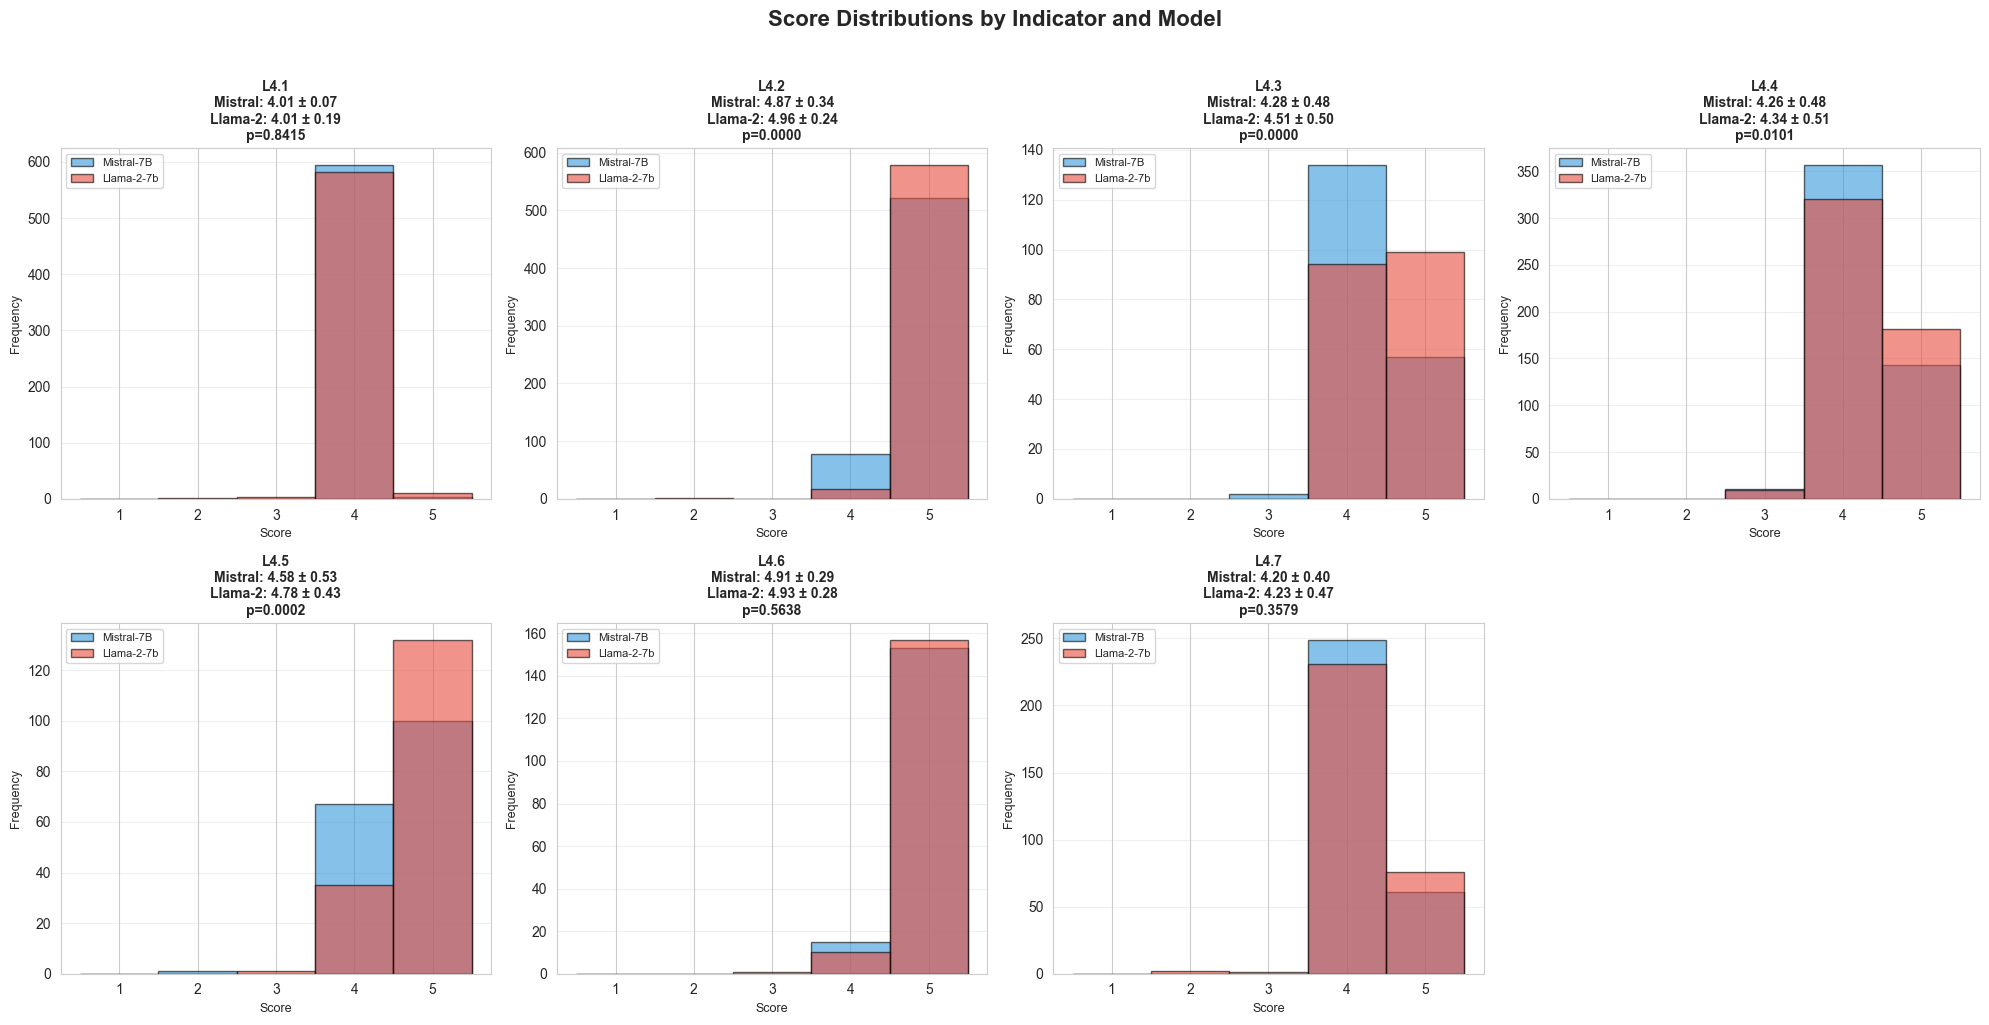

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ind in enumerate(indicators):
    ax = axes[idx]
    
    mistral_scores_list = np.array(mistral_scores.get(ind, []))
    llama_scores_list = np.array(llama_scores.get(ind, []))
    
    if len(mistral_scores_list) > 0 and len(llama_scores_list) > 0:
        ax.hist(mistral_scores_list, bins=range(1, 7), alpha=0.6, label='Mistral-7B', 
                color='#3498db', edgecolor='black', align='left')
        ax.hist(llama_scores_list, bins=range(1, 7), alpha=0.6, label='Llama-2-7b', 
                color='#e74c3c', edgecolor='black', align='left')
        
        row = comparison_df[comparison_df['Indicator'] == ind].iloc[0]
        ax.set_title(f'{ind}\nMistral: {row["Mistral_Mean"]:.2f} ± {row["Mistral_Std"]:.2f}\n'
                    f'Llama-2: {row["Llama_Mean"]:.2f} ± {row["Llama_Std"]:.2f}\n'
                    f'p={row["T_PValue"]:.4f}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Score', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_xticks(range(1, 6))
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

for idx in range(len(indicators), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Score Distributions by Indicator and Model', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / "score_distributions_by_indicator.png", dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / "score_distributions_by_indicator.pdf", bbox_inches='tight')
plt.show()


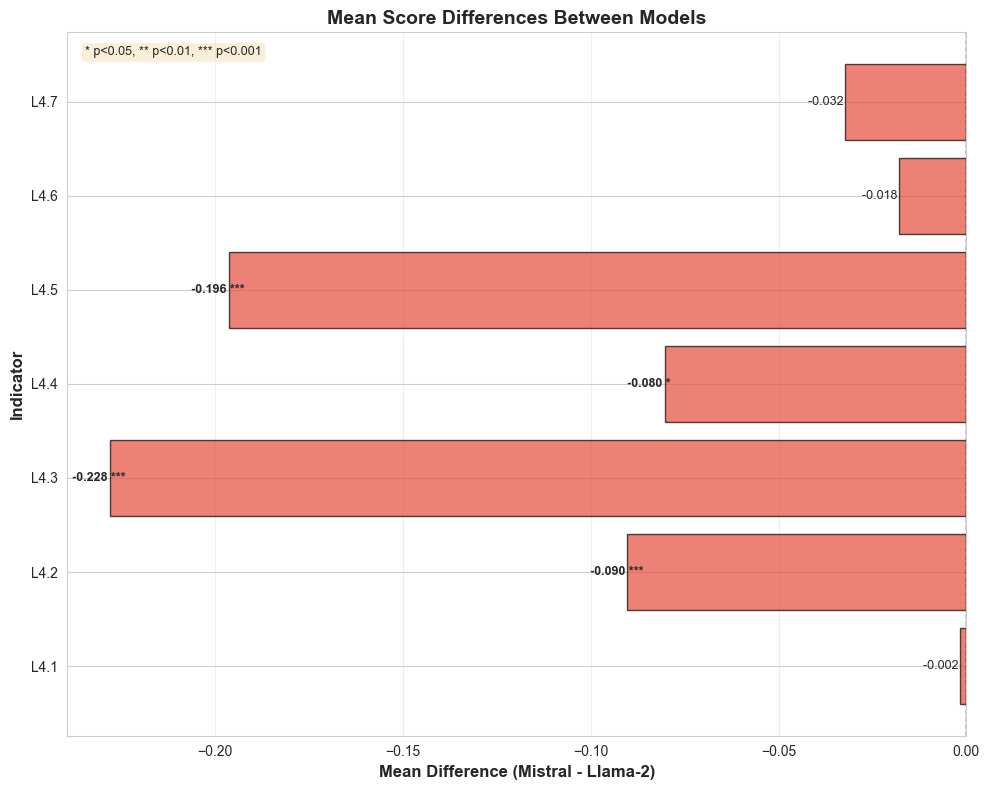

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

mean_diffs = comparison_df['Mean_Difference'].values
colors = ['#e74c3c' if diff < 0 else '#3498db' for diff in mean_diffs]

bars = ax.barh(indicators, mean_diffs, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Mean Difference (Mistral - Llama-2)', fontsize=12, fontweight='bold')
ax.set_ylabel('Indicator', fontsize=12, fontweight='bold')
ax.set_title('Mean Score Differences Between Models', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (bar, diff, p_val) in enumerate(zip(bars, mean_diffs, comparison_df['T_PValue'])):
    sig_text = ''
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    
    x_pos = diff + 0.01 if diff >= 0 else diff - 0.01
    ax.text(x_pos, i, f'{diff:.3f} {sig_text}', 
            va='center', fontsize=9, fontweight='bold' if sig_text else 'normal')

ax.text(0.02, 0.98, '* p<0.05, ** p<0.01, *** p<0.001', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(figures_dir / "mean_differences.png", dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / "mean_differences.pdf", bbox_inches='tight')
plt.show()


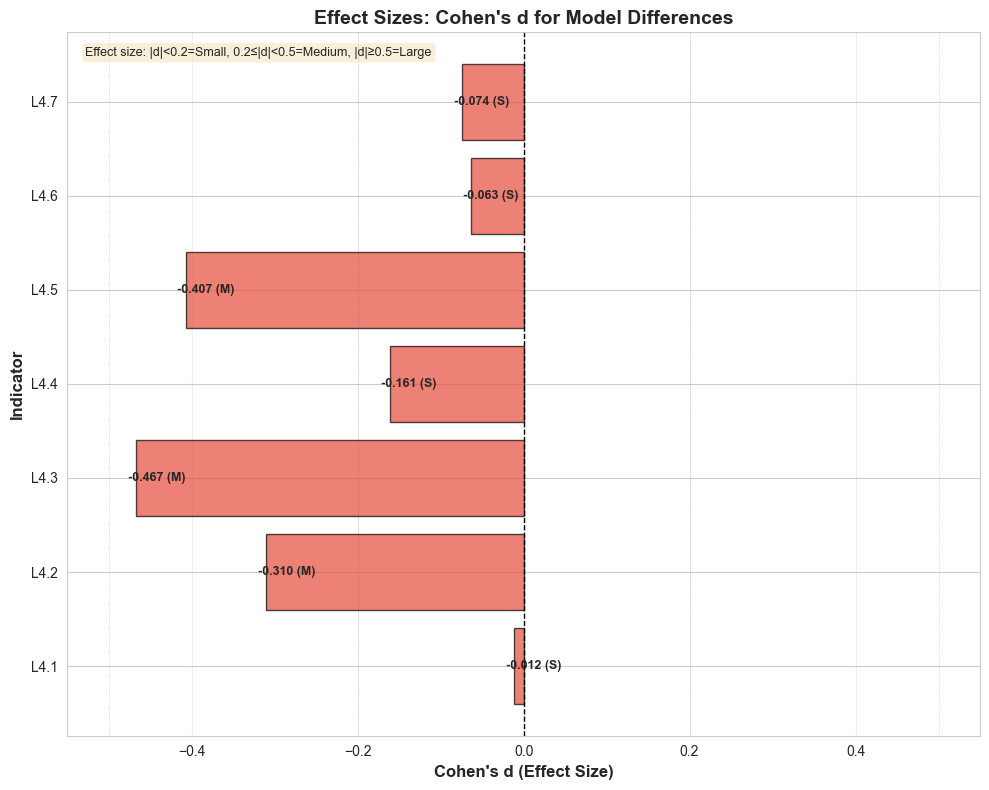

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

cohens_d_values = comparison_df['Cohens_D'].values
colors = ['#e74c3c' if d < 0 else '#3498db' for d in cohens_d_values]

bars = ax.barh(indicators, cohens_d_values, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=-0.2, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.axvline(x=0.2, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.axvline(x=-0.5, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

ax.set_xlabel("Cohen's d (Effect Size)", fontsize=12, fontweight='bold')
ax.set_ylabel('Indicator', fontsize=12, fontweight='bold')
ax.set_title("Effect Sizes: Cohen's d for Model Differences", fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (bar, d_val) in enumerate(zip(bars, cohens_d_values)):
    effect_size = 'Large' if abs(d_val) >= 0.5 else 'Medium' if abs(d_val) >= 0.2 else 'Small'
    x_pos = d_val + 0.01 if d_val >= 0 else d_val - 0.01
    ax.text(x_pos, i, f'{d_val:.3f} ({effect_size[0]})', 
            va='center', fontsize=9, fontweight='bold')

ax.text(0.02, 0.98, 'Effect size: |d|<0.2=Small, 0.2≤|d|<0.5=Medium, |d|≥0.5=Large', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(figures_dir / "cohens_d_effect_sizes.png", dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / "cohens_d_effect_sizes.pdf", bbox_inches='tight')
plt.show()


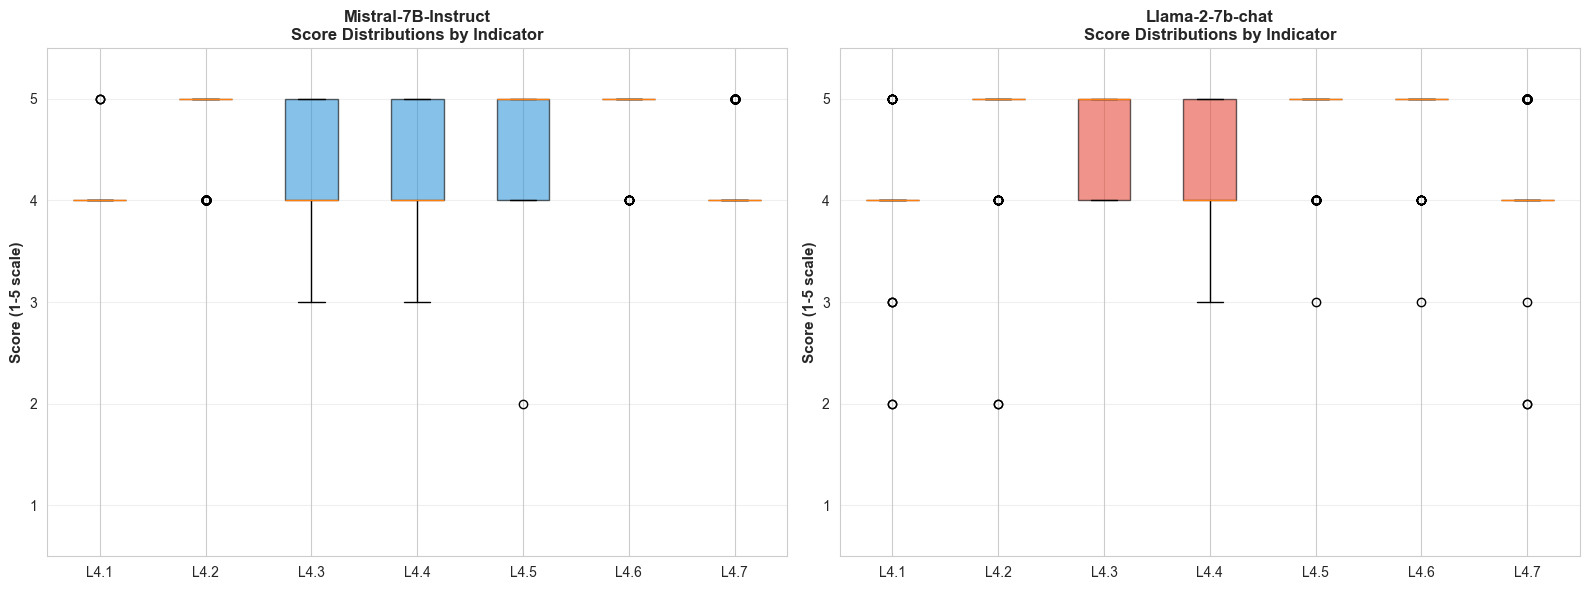

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, scores_dict, color) in enumerate([
    ('Mistral-7B-Instruct', mistral_scores, '#3498db'),
    ('Llama-2-7b-chat', llama_scores, '#e74c3c')
]):
    ax = axes[idx]
    
    data_for_box = []
    labels_for_box = []
    
    for ind in indicators:
        scores = scores_dict.get(ind, [])
        if len(scores) > 0:
            data_for_box.append(scores)
            labels_for_box.append(ind)
    
    bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Score (1-5 scale)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nScore Distributions by Indicator', 
                fontsize=12, fontweight='bold')
    ax.set_ylim([0.5, 5.5])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(labels_for_box, rotation=0)

plt.tight_layout()
plt.savefig(figures_dir / "box_plots_by_model.png", dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / "box_plots_by_model.pdf", bbox_inches='tight')
plt.show()


In [11]:
paper_table = comparison_df[['Indicator', 'Mistral_Mean', 'Mistral_CI_Low', 'Mistral_CI_High',
                               'Mistral_N', 'Llama_Mean', 'Llama_CI_Low', 'Llama_CI_High',
                               'Llama_N', 'Mean_Difference', 'T_PValue', 'Cohens_D']].copy()

paper_table.columns = ['Indicator', 'Mistral Mean', 'Mistral CI Low', 'Mistral CI High',
                       'Mistral N', 'Llama-2 Mean', 'Llama-2 CI Low', 'Llama-2 CI High',
                       'Llama-2 N', 'Difference', 'p-value (t-test)', "Cohen's d"]

for col in ['Mistral Mean', 'Mistral CI Low', 'Mistral CI High', 'Llama-2 Mean', 
            'Llama-2 CI Low', 'Llama-2 CI High', 'Difference', "Cohen's d"]:
    paper_table[col] = paper_table[col].round(3)

paper_table['p-value (t-test)'] = paper_table['p-value (t-test)'].round(4)

paper_table['Significant'] = paper_table['p-value (t-test)'] < 0.05
paper_table['Effect Size'] = paper_table["Cohen's d"].apply(
    lambda x: 'Large' if abs(x) >= 0.5 else 'Medium' if abs(x) >= 0.2 else 'Small'
)

print("\n" + "="*120)
print("FINAL COMPARATIVE ANALYSIS TABLE FOR PAPER")
print("="*120)
print(paper_table.to_string(index=False))
print("\n")

paper_table.to_csv(data_dir / "model_outputs" / "comparative_analysis_table.csv", index=False)
print(f"Table saved to: {data_dir / 'model_outputs' / 'comparative_analysis_table.csv'}")



FINAL COMPARATIVE ANALYSIS TABLE FOR PAPER
Indicator  Mistral Mean  Mistral CI Low  Mistral CI High  Mistral N  Llama-2 Mean  Llama-2 CI Low  Llama-2 CI High  Llama-2 N  Difference  p-value (t-test)  Cohen's d  Significant Effect Size
     L4.1         4.005           3.999            4.011        598         4.007           3.991            4.022        598      -0.002            0.8415     -0.012        False       Small
     L4.2         4.871           4.844            4.898        598         4.962           4.942            4.981        598      -0.090            0.0000     -0.310         True      Medium
     L4.3         4.285           4.218            4.352        193         4.513           4.442            4.584        193      -0.228            0.0000     -0.467         True      Medium
     L4.4         4.258           4.216            4.300        511         4.339           4.294            4.383        511      -0.080            0.0101     -0.161         True       Sm

In [12]:
print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

significant_indicators = paper_table[paper_table['Significant'] == True]
non_significant_indicators = paper_table[paper_table['Significant'] == False]

print(f"\nSignificant Differences (p < 0.05): {len(significant_indicators)}/{len(paper_table)}")
for _, row in significant_indicators.iterrows():
    direction = "Mistral > Llama-2" if row['Difference'] > 0 else "Llama-2 > Mistral"
    print(f"  {row['Indicator']}: {direction} (diff={row['Difference']:.3f}, "
          f"p={row['p-value (t-test)']:.4f}, d={row['Cohen\'s d']:.3f} [{row['Effect Size']}])")

print(f"\nNon-Significant Differences (p >= 0.05): {len(non_significant_indicators)}/{len(paper_table)}")
for _, row in non_significant_indicators.iterrows():
    print(f"  {row['Indicator']}: diff={row['Difference']:.3f}, p={row['p-value (t-test)']:.4f}")

print("\n" + "="*80)
print("OVERALL MODEL PERFORMANCE")
print("="*80)

mistral_overall = np.mean([np.mean(mistral_scores.get(ind, [])) for ind in indicators if len(mistral_scores.get(ind, [])) > 0])
llama_overall = np.mean([np.mean(llama_scores.get(ind, [])) for ind in indicators if len(llama_scores.get(ind, [])) > 0])

print(f"Mistral-7B-Instruct overall average: {mistral_overall:.3f}")
print(f"Llama-2-7b-chat overall average: {llama_overall:.3f}")
print(f"Overall difference: {mistral_overall - llama_overall:.3f}")

better_model = "Mistral-7B-Instruct" if mistral_overall > llama_overall else "Llama-2-7b-chat"
print(f"Better performing model (by average): {better_model}")



KEY FINDINGS SUMMARY

Significant Differences (p < 0.05): 4/7
  L4.2: Llama-2 > Mistral (diff=-0.090, p=0.0000, d=-0.310 [Medium])
  L4.3: Llama-2 > Mistral (diff=-0.228, p=0.0000, d=-0.467 [Medium])
  L4.4: Llama-2 > Mistral (diff=-0.080, p=0.0101, d=-0.161 [Small])
  L4.5: Llama-2 > Mistral (diff=-0.196, p=0.0002, d=-0.407 [Medium])

Non-Significant Differences (p >= 0.05): 3/7
  L4.1: diff=-0.002, p=0.8415
  L4.6: diff=-0.018, p=0.5638
  L4.7: diff=-0.032, p=0.3579

OVERALL MODEL PERFORMANCE
Mistral-7B-Instruct overall average: 4.444
Llama-2-7b-chat overall average: 4.537
Overall difference: -0.092
Better performing model (by average): Llama-2-7b-chat
